In [38]:
import glob
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
from scipy.stats import gaussian_kde
import seaborn as sns
import re

import importlib
import toylosses
importlib.reload(toylosses)
import toynn
importlib.reload(toynn)
import toyvis
importlib.reload(toyvis)

import torch
#sns.set()

import toypipeline
importlib.reload(toypipeline)

DEVICE = 'cuda'
OUTPUT = '/scratch/users/nmiolane/toyoutput'

# Decide on experiment's configuration

In [39]:
DATA_DIM = 1
LATENT_DIM = 1
N_DECODER_LAYERS = 1
NONLINEARITY = False
N_SAMPLES = 10000
WITH_BIASX = False
WITH_LOGVARX = False

FRAC_VAL = 0.2

W_TRUE = {}
B_TRUE = {}

W_TRUE[0] = [[2.]]

if WITH_LOGVARX:
    assert len(W_TRUE) == N_DECODER_LAYERS + 1, len(W_TRUE)
else:
    assert len(W_TRUE) == N_DECODER_LAYERS

WITH_BIASZ = False
WITH_LOGVARZ = False

# Safety checks on configuration

In [40]:
assert DATA_DIM == toypipeline.DATA_DIM
assert LATENT_DIM == toypipeline.LATENT_DIM
assert N_DECODER_LAYERS == toypipeline.N_DECODER_LAYERS
assert NONLINEARITY == toypipeline.NONLINEARITY
assert N_SAMPLES == toypipeline.N_SAMPLES
assert WITH_BIASX == toypipeline.WITH_BIASX
assert WITH_LOGVARX == toypipeline.WITH_LOGVARX
assert FRAC_VAL == toypipeline.FRAC_VAL
assert W_TRUE == toypipeline.W_TRUE
assert B_TRUE == toypipeline.B_TRUE
assert WITH_BIASZ == toypipeline.WITH_BIASZ
assert WITH_LOGVARZ == toypipeline.WITH_LOGVARZ

print('CONSTANTS: Safety CHECKED.')

CONSTANTS: Safety CHECKED.


In [41]:
dataset_path = glob.glob(f'{OUTPUT}/synthetic/dataset.npy')[0]
dataset = np.load(dataset_path)

assert len(dataset) == N_SAMPLES

print('Dataset: Safety CHECKED.')

Dataset: Safety CHECKED.


# Inspect Functions

# Inspect generation of synthetic data from decoder_true

layers.0.weight tensor([[2.]], device='cuda:0') 



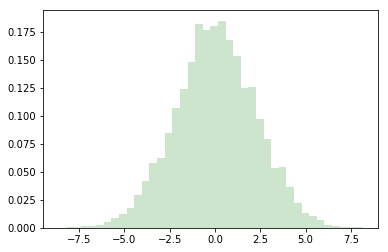

In [52]:
decoder_true_path = glob.glob(f'{OUTPUT}/synthetic/decoder_true.pth')[0]
decoder_true = torch.load(decoder_true_path, map_location=DEVICE)

for name, param in decoder_true.named_parameters():
    print(name, param.data, '\n')
    
generated_true_x = toynn.generate_from_decoder(decoder_true, N_SAMPLES)

fig, ax = plt.subplots()
ax = toyvis.plot_data(generated_true_x, color='green', label='from decoder true', ax=ax)

# Get synthetized data and corresponding MLE

In [53]:
train_w_mle, train_min_neg_ll = min_neg_ll()
val_w_mle, val_min_neg_ll = min_neg_ll(val=True)

train_w_elbo, train_elbo_neg_ll = elbo_neg_ll()
val_w_elbo, val_elbo_neg_ll = elbo_neg_ll(val=True)

# Training set
print('The maximum likelihood estimator on this train dataset is:')
print(train_w_mle)

print('The corresponding value for the negative log-likelihood for the training set is:')
print(train_min_neg_ll)

print('The w_elbo estimator on this train dataset is:')
print(train_w_elbo)

print('The corresponding value for the negative log-likelihood for the training set is:')
print(train_elbo_neg_ll)

print('\n')

# Validation set

print('The maximum likelihood estimator on this val dataset is:')
print(val_w_mle)

print('The corresponding value for the negative log-likelihood for the validation set is:')
print(val_min_neg_ll)

print('The w_elbo estimator on this validation dataset is:')
print(val_w_elbo)

print('The corresponding value for the negative log-likelihood for the validation set is:')
print(val_elbo_neg_ll)

The maximum likelihood estimator on this train dataset is:
[1.975533]
The corresponding value for the negative log-likelihood for the training set is:
[2.2138348]
The w_elbo estimator on this train dataset is:
[1.2377486]
The corresponding value for the negative log-likelihood for the training set is:
[2.3834476]


The maximum likelihood estimator on this val dataset is:
[2.0159473]
The corresponding value for the negative log-likelihood for the validation set is:
[2.2300212]
The w_elbo estimator on this validation dataset is:
[1.2377486]
The corresponding value for the negative log-likelihood for the validation set is:
[2.3834476]


# Comparison of Convergences

In [57]:
from_epoch = 1
to_epoch = 200

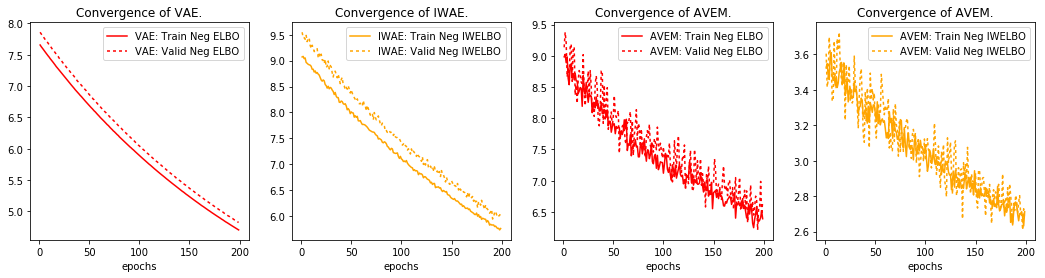

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

ax = axes[0]
ax = plot_convergence(ax, 'vae', 'neg_elbo')

ax = axes[1]
ax = plot_convergence(ax, 'iwae', 'neg_iwelbo')

ax = axes[2]
ax = plot_convergence(ax, 'vem', 'neg_elbo')
ax = axes[3]
ax = plot_convergence(ax, 'vem', 'neg_iwelbo')

Text(0.5, 1.0, 'Convergence in parameters (Zoom)')

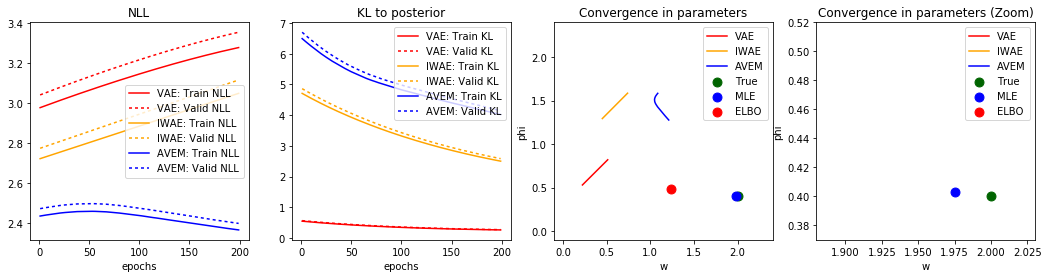

In [59]:

fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(18, 4))

ax = axes[0]
ax = plot_nll(ax, 'vae')
ax = plot_nll(ax, 'iwae')
ax = plot_nll(ax, 'vem')
ax.set_title('NLL')

ax = axes[1]
ax = plot_kl(ax, 'vae')
ax = plot_kl(ax, 'iwae')
ax = plot_kl(ax, 'vem')
ax.legend()
ax.set_title('KL to posterior')

ax = axes[2]
ax = plot_weights_landscape(ax, from_epoch=from_epoch, to_epoch=to_epoch)
ax.set_xlim((-0.1, 2.4)) 
ax.set_ylim((-0.1, 2.4))
ax.legend()
ax.set_title('Convergence in parameters')

ax = axes[3]
ax = plot_weights_landscape(ax, from_epoch=from_epoch, to_epoch=to_epoch)

ax.set_xlim((1.88, 2.03)) 
ax.set_ylim((0.37, 0.52))
ax.set_title('Convergence in parameters (Zoom)')

# Comparison of data distribution and posterior distributions

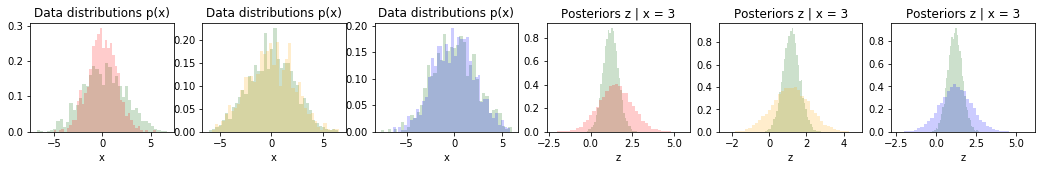

In [30]:
algo_name = 'iwae'

fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(18, 2))

ax = axes[0]
ax = plot_data_distribution(ax, 'vae')

ax = axes[1]
ax = plot_data_distribution(ax, 'iwae')

ax = axes[2]
ax = plot_data_distribution(ax, 'vem')

ax = axes[3]
ax = plot_posterior(ax, 'vae')

ax = axes[4]
ax = plot_posterior(ax, 'iwae')

ax = axes[5]
ax = plot_posterior(ax, 'vem')

# Comparison of times

In [31]:
   
print_average_time('vae')
print_average_time('iwae')
print_average_time('vem')

0.06083973050117493
0.0656246930360794
0.13609812259674073


# Print pipeline logs

In [160]:
pattern = 'logs'
logs = []
for filename in os.listdir(OUTPUT):
    if re.search(pattern, filename):
        logs.append(filename)

print('Found %d log files.' % len(logs))
        
for filename in logs:
    path = os.path.join(OUTPUT, filename)
    print('\n-- Log file: %s\n' % filename)
    with open(path, 'r') as f:
        message = f.read()
    print(message)

Found 1 log files.

-- Log file: logs2019-05-17 22:05:22.503695.txt

2019-05-17 22:05:22,503 root         INFO     start
2019-05-17 22:05:22,518 luigi        INFO     logging configured by default settings
2019-05-17 22:05:22,542 luigi-interface DEBUG    Checking if RunAll() is complete
2019-05-17 22:05:22,543 luigi-interface DEBUG    Checking if Report() is complete
2019-05-17 22:05:22,543 luigi-interface INFO     Informed scheduler that task   RunAll__99914b932b   has status   PENDING
2019-05-17 22:05:22,544 luigi-interface DEBUG    Checking if TrainVAE() is complete
2019-05-17 22:05:22,544 luigi-interface DEBUG    Checking if TrainIWAE() is complete
2019-05-17 22:05:22,545 luigi-interface DEBUG    Checking if TrainVEM() is complete
2019-05-17 22:05:22,545 luigi-interface INFO     Informed scheduler that task   Report__99914b932b   has status   PENDING
2019-05-17 22:05:22,546 luigi-interface DEBUG    Checking if MakeDataSet() is complete
2019-05-17 22:05:22,546 luigi-interface INFO  